In [2]:
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import datetime as dt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import seaborn as sns
import sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import and Clean Data

In [3]:
# import the cleaned HPI csv data and assign to a dataframe with date as index
csv = Path("clean_data/top20_hpi_monthly_full.csv")
df = pd.read_csv(csv)
df.head()

,MSA,Year,HPI
0,"Baltimore-Columbia-Towson, MD",1975-01-31,26.81
1,"Baltimore-Columbia-Towson, MD",1975-02-28,26.79
2,"Baltimore-Columbia-Towson, MD",1975-03-31,26.77
3,"Baltimore-Columbia-Towson, MD",1975-04-30,26.78
4,"Baltimore-Columbia-Towson, MD",1975-05-31,26.85


In [4]:
# convert year column into datetime format
df['Year'] = pd.to_datetime(df['Year'])
df.head()

,MSA,Year,HPI
0,"Baltimore-Columbia-Towson, MD",1975-01-31,26.81
1,"Baltimore-Columbia-Towson, MD",1975-02-28,26.79
2,"Baltimore-Columbia-Towson, MD",1975-03-31,26.77
3,"Baltimore-Columbia-Towson, MD",1975-04-30,26.78
4,"Baltimore-Columbia-Towson, MD",1975-05-31,26.85


In [5]:
# set index as date column
df.index = df['Year']
df.drop(columns='Year')

,MSA,HPI
Year,,
1975-01-31,"Baltimore-Columbia-Towson, MD",26.81
1975-02-28,"Baltimore-Columbia-Towson, MD",26.79
1975-03-31,"Baltimore-Columbia-Towson, MD",26.77
1975-04-30,"Baltimore-Columbia-Towson, MD",26.78
1975-05-31,"Baltimore-Columbia-Towson, MD",26.85
...,...,...
2020-08-31,"Washington-Arlington-Alexandria, DC-VA-MD-WV",246.01
2020-09-30,"Washington-Arlington-Alexandria, DC-VA-MD-WV",247.94
2020-10-31,"Washington-Arlington-Alexandria, DC-VA-MD-WV",249.42


In [6]:
# check for nulls in data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11040 entries, 1975-01-31 to 2020-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MSA     11040 non-null  object        
 1   Year    11040 non-null  datetime64[ns]
 2   HPI     11040 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 345.0+ KB


# Splice Data for Top 5 MSA

In [12]:
# New York
df_ny = df.loc[df['MSA']== "New York-Newark-Jersey City, NY-NJ-PA"]
df_ny.drop(columns='Year',inplace=True)
df_ny.head()

,MSA,HPI
Year,,
1975-01-31,"New York-Newark-Jersey City, NY-NJ-PA",20.25
1975-02-28,"New York-Newark-Jersey City, NY-NJ-PA",19.81
1975-03-31,"New York-Newark-Jersey City, NY-NJ-PA",19.57
1975-04-30,"New York-Newark-Jersey City, NY-NJ-PA",19.55
1975-05-31,"New York-Newark-Jersey City, NY-NJ-PA",19.64


In [13]:
# Los Angeles
df_la = df.loc[df['MSA']== "Los Angeles-Long Beach-Anaheim, CA"]
df_la.drop(columns='Year',inplace=True)
df_la.head()

,MSA,HPI
Year,,
1975-01-31,"Los Angeles-Long Beach-Anaheim, CA",15.76
1975-02-28,"Los Angeles-Long Beach-Anaheim, CA",15.89
1975-03-31,"Los Angeles-Long Beach-Anaheim, CA",16.16
1975-04-30,"Los Angeles-Long Beach-Anaheim, CA",16.54
1975-05-31,"Los Angeles-Long Beach-Anaheim, CA",16.86


In [14]:
# Chicago
df_chi = df.loc[df['MSA']== "Chicago-Naperville-Elgin, IL-IN-WI"]
df_chi.drop(columns='Year',inplace=True)
df_chi.head()

,MSA,HPI
Year,,
1975-01-31,"Chicago-Naperville-Elgin, IL-IN-WI",23.10
1975-02-28,"Chicago-Naperville-Elgin, IL-IN-WI",23.13
1975-03-31,"Chicago-Naperville-Elgin, IL-IN-WI",23.28
1975-04-30,"Chicago-Naperville-Elgin, IL-IN-WI",23.49
1975-05-31,"Chicago-Naperville-Elgin, IL-IN-WI",23.59


In [15]:
# DFW
df_dfw = df.loc[df['MSA']== "Dallas-Fort Worth-Arlington, TX"]
df_dfw.drop(columns='Year',inplace=True)
df_dfw.head()

,MSA,HPI
Year,,
1975-01-31,"Dallas-Fort Worth-Arlington, TX",31.87
1975-02-28,"Dallas-Fort Worth-Arlington, TX",31.92
1975-03-31,"Dallas-Fort Worth-Arlington, TX",32.28
1975-04-30,"Dallas-Fort Worth-Arlington, TX",32.96
1975-05-31,"Dallas-Fort Worth-Arlington, TX",33.07


In [16]:
# Houston
df_hou = df.loc[df['MSA']== "Houston-The Woodlands-Sugar Land, TX"]
df_hou.drop(columns='Year',inplace=True)
df_hou.head()

,MSA,HPI
Year,,
1975-01-31,"Houston-The Woodlands-Sugar Land, TX",32.71
1975-02-28,"Houston-The Woodlands-Sugar Land, TX",32.98
1975-03-31,"Houston-The Woodlands-Sugar Land, TX",33.58
1975-04-30,"Houston-The Woodlands-Sugar Land, TX",34.52
1975-05-31,"Houston-The Woodlands-Sugar Land, TX",34.87


# TimeSeries Forecasting

New York

In [17]:
# Monthly housing price index
ts = df_ny['HPI']
ts.head(10)

Year
1975-01-31    20.25
1975-02-28    19.81
1975-03-31    19.57
1975-04-30    19.55
1975-05-31    19.64
1975-06-30    19.80
1975-07-31    20.02
1975-08-31    20.17
1975-09-30    20.20
1975-10-31    20.18
Name: HPI, dtype: float64

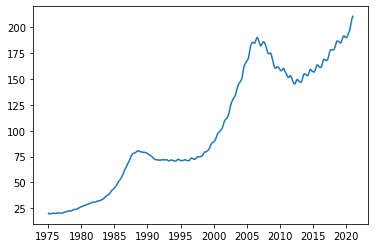

In [18]:
# plot trend of HPI
plt.plot(ts)

In [19]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = sts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

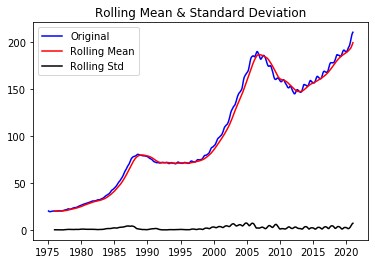

Results of Dickey-Fuller Test:
Test Statistic                   0.263971
p-value                          0.975630
#Lags Used                      19.000000
Number of Observations Used    532.000000
Critical Value (1%)             -3.442702
Critical Value (5%)             -2.866988
Critical Value (10%)            -2.569672
dtype: float64


In [20]:
test_stationarity(ts) #not stationary because tstat > that critical values and pvalue > 5%

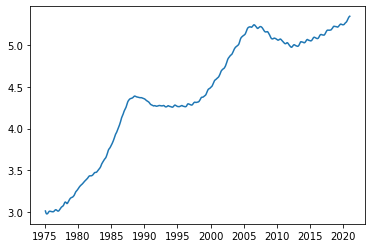

In [21]:
#take log of time series to reduce trend
ts_log = np.log(ts)
plt.plot(ts_log)

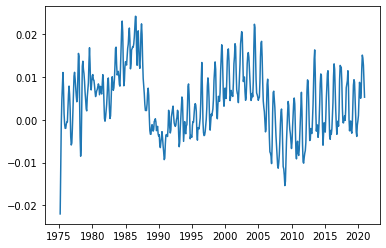

In [22]:
#take difference of logged time series to make stationary
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

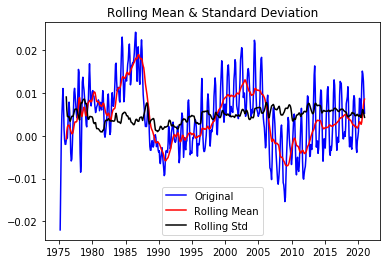

Results of Dickey-Fuller Test:
Test Statistic                  -3.021260
p-value                          0.032956
#Lags Used                      18.000000
Number of Observations Used    532.000000
Critical Value (1%)             -3.442702
Critical Value (5%)             -2.866988
Critical Value (10%)            -2.569672
dtype: float64


In [23]:
# this shows that the ts_log_diff is stationary because tstat < critical values at 5%, and pvalue is < 5%
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

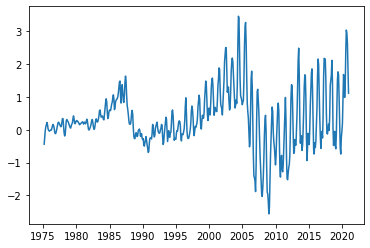

In [24]:
#alternate (taking difference without logged ts)
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

In [25]:
ts_diff.dropna(inplace=True)

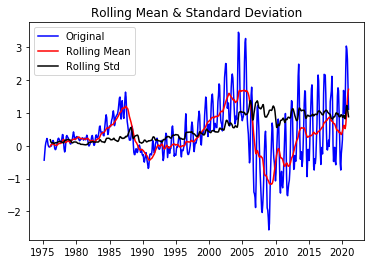

Results of Dickey-Fuller Test:
Test Statistic                  -2.586152
p-value                          0.095893
#Lags Used                      18.000000
Number of Observations Used    532.000000
Critical Value (1%)             -3.442702
Critical Value (5%)             -2.866988
Critical Value (10%)            -2.569672
dtype: float64


In [26]:
test_stationarity(ts_diff)

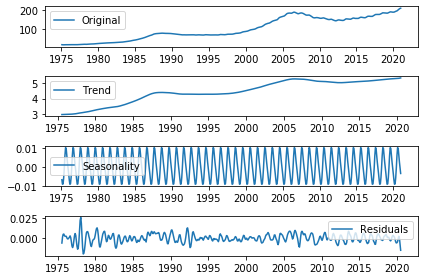

In [27]:
#alternate way of pulling out seasonality and trend
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

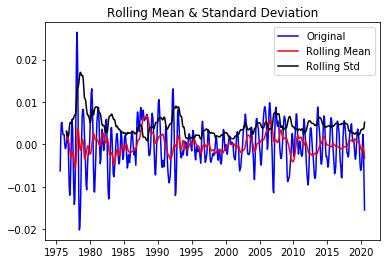

Results of Dickey-Fuller Test:
Test Statistic                  -5.094304
p-value                          0.000014
#Lags Used                      16.000000
Number of Observations Used    523.000000
Critical Value (1%)             -3.442915
Critical Value (5%)             -2.867082
Critical Value (10%)            -2.569722
dtype: float64


In [28]:
#use with above cell if decomposition is needed
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

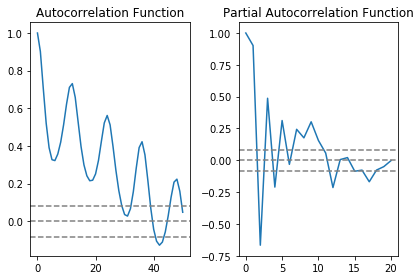

In [29]:
#ignore
lag_acf = sts.acf(ts_log_diff, nlags=50)
lag_pacf = sts.pacf(ts_log_diff, nlags=20, method='ols')

#plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

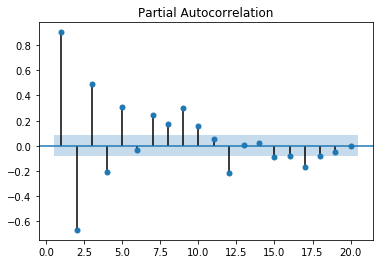

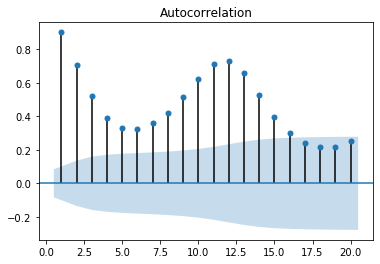

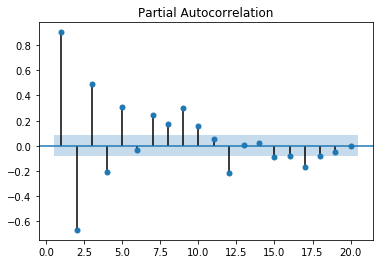

In [30]:
#use this to find ACF and PACF
sgt.plot_acf(ts_log_diff, lags=20, zero=False)
sgt.plot_pacf(ts_log_diff, lags=20, method='ols', zero=False)

Text(0.5, 1.0, 'RSS: 0.0091')

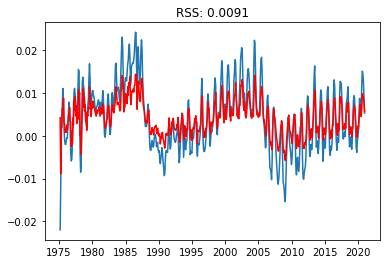

In [31]:
model011 = ARIMA(ts_log, order=(0,1,1))
results011 = model011.fit()
plt.plot(ts_log_diff)
plt.plot(results011.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results011.fittedvalues-ts_log_diff)**2))

In [32]:
results011.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2262.048
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 13 Jun 2021   AIC                          -4518.095
Time:                        11:24:49   BIC                          -4505.160
Sample:                    02-28-1975   HQIC                         -4513.041
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0042      0.000     12.523      0.000       0.004       0.005
ma.L1.D.HPI     0.9999      0.005    197.593      0.000       0.990       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0059')

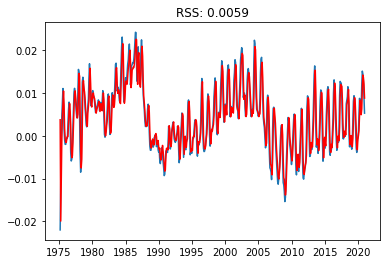

In [38]:
model110 = ARIMA(ts_log, order=(1,1,0))
results110 = model110.fit()
plt.plot(ts_log_diff)
plt.plot(results110.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results110.fittedvalues-ts_log_diff)**2))

In [39]:
results110.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2397.586
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 12 Jun 2021   AIC                          -4789.172
Time:                        12:07:59   BIC                          -4776.237
Sample:                    02-28-1975   HQIC                         -4784.118
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0037      0.002      2.304      0.021       0.001       0.007
ar.L1.D.HPI     0.9199      0.017     52.601      0.000       0.886       0.954
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0871           +0.0000j            1.0871            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0022')

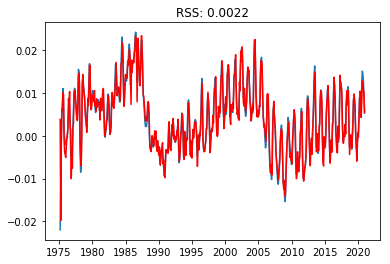

In [40]:
model515 = ARIMA(ts_log, order=(5,1,5))
results515 = model515.fit()
plt.plot(ts_log_diff)
plt.plot(results515.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results515.fittedvalues-ts_log_diff)**2))

In [41]:
results515.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 5)   Log Likelihood                2747.983
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5471.966
Time:                        12:08:12   BIC                          -5420.225
Sample:                    02-28-1975   HQIC                         -5451.748
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0038      0.003      1.451      0.147      -0.001       0.009
ar.L1.D.HPI     3.0981      0.032     95.744      0.000       3.035       3.161
ar.L2.D.HPI    -3.8492      0.068    -56.436      0.000      -3.983      -3.716
ar.L3.D.HPI     2.3083        nan        nan        nan         nan         nan
ar.L4.D.HPI    -0.6636        nan        nan        nan         nan         nan
ar.L5.D.HPI     0.1027        nan        nan        nan         nan         nan
ma.L1.D.HPI    -1.2242      0.050    -24.243      0.000      -1.323      -1.125
ma.L2.D.HPI    -0.4039      0.052     -7.768      0.000      -0.506      -0.302
ma.L3.D.HPI     1.0258      0.047     21.626      0.000       0.933       1.119
ma.L4.D.HPI     0.0105      0.062      0.171      0.865      -0.110       0.131
ma.L5.D.HPI    -0.2559      0.026     -9.692      0.000      -0.308      -0.204
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8695           -0.5008j            1.0034           -0.0832
AR.2            0.8695           +0.5008j            1.0034            0.0832
AR.3            1.0199           -0.0000j            1.0199           -0.0000
AR.4            1.8510           -2.4607j            3.0792           -0.1474
AR.5            1.8510           +2.4607j            3.0792            0.1474
MA.1            0.9245           -0.4771j            1.0404           -0.0758
MA.2            0.9245           +0.4771j            1.0404            0.0758
MA.3            1.3745           -0.0000j            1.3745           -0.0000
MA.4           -1.5912           -0.3075j            1.6206           -0.4696
MA.5           -1.5912           +0.3075j            1.6206            0.4696
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0021')

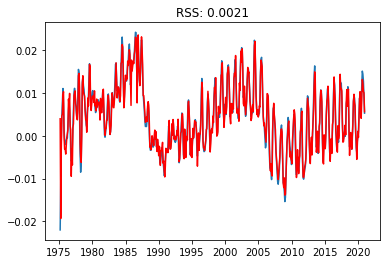

In [42]:
model514 = ARIMA(ts_log, order=(5,1,4))
results514 = model514.fit()
plt.plot(ts_log_diff)
plt.plot(results514.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results514.fittedvalues-ts_log_diff)**2))

In [43]:
results514.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 4)   Log Likelihood                2752.455
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5482.911
Time:                        12:08:26   BIC                          -5435.482
Sample:                    02-28-1975   HQIC                         -5464.378
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0040      0.002      2.487      0.013       0.001       0.007
ar.L1.D.HPI     3.3877      0.108     31.466      0.000       3.177       3.599
ar.L2.D.HPI    -4.9856      0.301    -16.549      0.000      -5.576      -4.395
ar.L3.D.HPI     4.0289      0.336     11.999      0.000       3.371       4.687
ar.L4.D.HPI    -1.8698      0.180    -10.390      0.000      -2.223      -1.517
ar.L5.D.HPI     0.4317      0.045      9.580      0.000       0.343       0.520
ma.L1.D.HPI    -1.5031      0.124    -12.089      0.000      -1.747      -1.259
ma.L2.D.HPI     0.2050      0.139      1.479      0.139      -0.067       0.477
ma.L3.D.HPI     0.8162      0.100      8.136      0.000       0.620       1.013
ma.L4.D.HPI    -0.3445      0.104     -3.313      0.001      -0.548      -0.141
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0377           -0.0000j            1.0377           -0.0000
AR.2            0.8740           -0.5020j            1.0080           -0.0830
AR.3            0.8740           +0.5020j            1.0080            0.0830
AR.4            0.7728           -1.2649j            1.4823           -0.1627
AR.5            0.7728           +1.2649j            1.4823            0.1627
MA.1           -1.3911           -0.0000j            1.3911           -0.5000
MA.2            0.9329           -0.4807j            1.0495           -0.0757
MA.3            0.9329           +0.4807j            1.0495            0.0757
MA.4            1.8943           -0.0000j            1.8943           -0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0022')

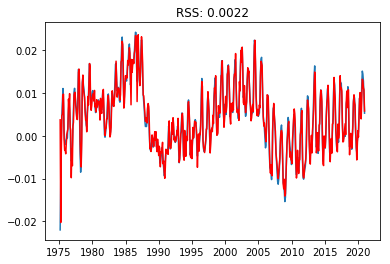

In [44]:
model513 = ARIMA(ts_log, order=(5,1,3))
results513 = model513.fit()
plt.plot(ts_log_diff)
plt.plot(results513.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results513.fittedvalues-ts_log_diff)**2))

In [45]:
results513=model513.fit(disp=0)

In [46]:
results513.summary() ## best so far

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 3)   Log Likelihood                2743.429
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5466.859
Time:                        12:09:34   BIC                          -5423.741
Sample:                    02-28-1975   HQIC                         -5450.011
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0037      0.003      1.471      0.141      -0.001       0.009
ar.L1.D.HPI     2.9682      0.063     47.213      0.000       2.845       3.091
ar.L2.D.HPI    -3.7402      0.206    -18.196      0.000      -4.143      -3.337
ar.L3.D.HPI     2.6020      0.284      9.175      0.000       2.046       3.158
ar.L4.D.HPI    -1.1513      0.199     -5.773      0.000      -1.542      -0.760
ar.L5.D.HPI     0.3136      0.061      5.176      0.000       0.195       0.432
ma.L1.D.HPI    -1.0364      0.056    -18.537      0.000      -1.146      -0.927
ma.L2.D.HPI    -0.2779      0.099     -2.797      0.005      -0.473      -0.083
ma.L3.D.HPI     0.6084      0.050     12.179      0.000       0.510       0.706
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0291           -0.0000j            1.0291           -0.0000
AR.2            0.8814           -0.5084j            1.0175           -0.0833
AR.3            0.8814           +0.5084j            1.0175            0.0833
AR.4            0.4396           -1.6732j            1.7300           -0.2091
AR.5            0.4396           +1.6732j            1.7300            0.2091
MA.1           -1.4675           -0.0000j            1.4675           -0.5000
MA.2            0.9621           -0.4410j            1.0583           -0.0684
MA.3            0.9621           +0.4410j            1.0583            0.0684
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0024')

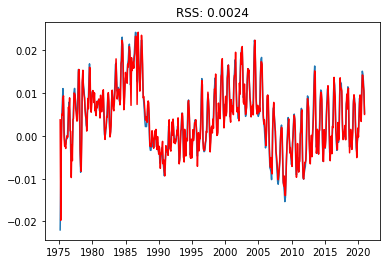

In [47]:
model512 = ARIMA(ts_log, order=(5,1,2))
results512 = model512.fit()
plt.plot(ts_log_diff)
plt.plot(results512.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results512.fittedvalues-ts_log_diff)**2))

In [48]:
results512.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 2)   Log Likelihood                2711.480
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5404.960
Time:                        12:09:37   BIC                          -5366.155
Sample:                    02-28-1975   HQIC                         -5389.797
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0037      0.002      1.504      0.133      -0.001       0.009
ar.L1.D.HPI     2.2046      0.078     28.277      0.000       2.052       2.357
ar.L2.D.HPI    -1.9499      0.210     -9.293      0.000      -2.361      -1.539
ar.L3.D.HPI     1.0084      0.257      3.926      0.000       0.505       1.512
ar.L4.D.HPI    -0.4828      0.178     -2.707      0.007      -0.832      -0.133
ar.L5.D.HPI     0.2119      0.060      3.508      0.000       0.094       0.330
ma.L1.D.HPI    -0.1773      0.075     -2.376      0.018      -0.324      -0.031
ma.L2.D.HPI    -0.5371      0.069     -7.811      0.000      -0.672      -0.402
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0170           -0.0000j            1.0170           -0.0000
AR.2            0.9656           -0.6554j            1.1670           -0.0949
AR.3            0.9656           +0.6554j            1.1670            0.0949
AR.4           -0.3349           -1.8151j            1.8457           -0.2790
AR.5           -0.3349           +1.8151j            1.8457            0.2790
MA.1            1.2094           +0.0000j            1.2094            0.0000
MA.2           -1.5395           +0.0000j            1.5395            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0022')

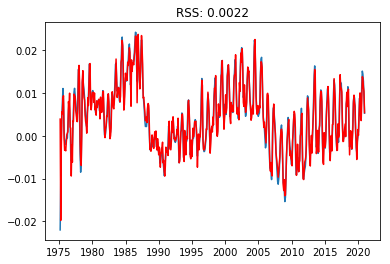

In [49]:
model415 = ARIMA(ts_log, order=(4,1,5))
results415 = model415.fit()
plt.plot(ts_log_diff)
plt.plot(results415.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results415.fittedvalues-ts_log_diff)**2))

In [50]:
results415.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(4, 1, 5)   Log Likelihood                2735.209
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5448.419
Time:                        12:09:48   BIC                          -5400.990
Sample:                    02-28-1975   HQIC                         -5429.886
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0039      0.002      2.036      0.042       0.000       0.008
ar.L1.D.HPI     1.7196      0.127     13.499      0.000       1.470       1.969
ar.L2.D.HPI    -0.1771      0.325     -0.545      0.586      -0.814       0.460
ar.L3.D.HPI    -1.3276      0.308     -4.310      0.000      -1.931      -0.724
ar.L4.D.HPI     0.7658      0.110      6.987      0.000       0.551       0.981
ma.L1.D.HPI     0.2239      0.135      1.658      0.097      -0.041       0.489
ma.L2.D.HPI    -1.3840      0.089    -15.471      0.000      -1.559      -1.209
ma.L3.D.HPI    -0.1935      0.137     -1.414      0.157      -0.462       0.075
ma.L4.D.HPI     0.6950      0.072      9.668      0.000       0.554       0.836
ma.L5.D.HPI     0.1986      0.064      3.105      0.002       0.073       0.324
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1307           -0.0000j            1.1307           -0.5000
AR.2            0.9115           -0.5274j            1.0531           -0.0835
AR.3            0.9115           +0.5274j            1.0531            0.0835
AR.4            1.0415           -0.0000j            1.0415           -0.0000
MA.1            0.9968           -0.3707j            1.0635           -0.0567
MA.2            0.9968           +0.3707j            1.0635            0.0567
MA.3           -1.1925           -0.1020j            1.1969           -0.4864
MA.4           -1.1925           +0.1020j            1.1969            0.4864
MA.5           -3.1082           -0.0000j            3.1082           -0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0022')

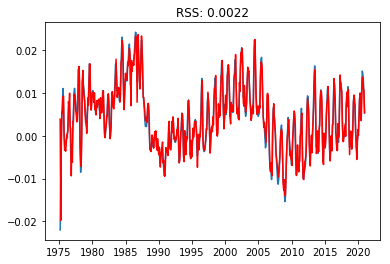

In [51]:
model414 = ARIMA(ts_log, order=(4,1,4))
results414 = model414.fit()
plt.plot(ts_log_diff)
plt.plot(results414.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results414.fittedvalues-ts_log_diff)**2))

In [52]:
results414.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(4, 1, 4)   Log Likelihood                2735.516
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5451.033
Time:                        12:09:56   BIC                          -5407.916
Sample:                    02-28-1975   HQIC                         -5434.185
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0039      0.002      2.015      0.044       0.000       0.008
ar.L1.D.HPI     2.4588      0.143     17.206      0.000       2.179       2.739
ar.L2.D.HPI    -2.0966      0.377     -5.560      0.000      -2.836      -1.358
ar.L3.D.HPI     0.4924      0.370      1.332      0.183      -0.232       1.217
ar.L4.D.HPI     0.1338      0.134      0.997      0.319      -0.129       0.397
ma.L1.D.HPI    -0.5229      0.134     -3.895      0.000      -0.786      -0.260
ma.L2.D.HPI    -0.9015      0.114     -7.919      0.000      -1.125      -0.678
ma.L3.D.HPI     0.4136      0.083      4.997      0.000       0.251       0.576
ma.L4.D.HPI     0.3381      0.093      3.647      0.000       0.156       0.520
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0404           -0.0000j            1.0404           -0.0000
AR.2            0.9073           -0.5255j            1.0485           -0.0835
AR.3            0.9073           +0.5255j            1.0485            0.0835
AR.4           -6.5369           -0.0000j            6.5369           -0.5000
MA.1            0.9963           -0.3766j            1.0651           -0.0575
MA.2            0.9963           +0.3766j            1.0651            0.0575
MA.3           -1.6079           -0.1472j            1.6147           -0.4855
MA.4           -1.6079           +0.1472j            1.6147            0.4855
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0022')

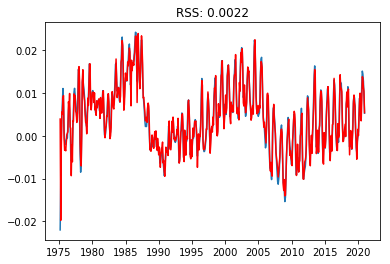

In [53]:
model314 = ARIMA(ts_log, order=(3,1,4))
results314 = model314.fit()
plt.plot(ts_log_diff)
plt.plot(results314.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results314.fittedvalues-ts_log_diff)**2))

In [54]:
results314.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(3, 1, 4)   Log Likelihood                2735.004
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5452.007
Time:                        12:10:00   BIC                          -5413.202
Sample:                    02-28-1975   HQIC                         -5436.844
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0039      0.002      2.055      0.040       0.000       0.008
ar.L1.D.HPI     2.5999      0.026     99.389      0.000       2.549       2.651
ar.L2.D.HPI    -2.4712      0.050    -49.389      0.000      -2.569      -2.373
ar.L3.D.HPI     0.8610      0.027     32.460      0.000       0.809       0.913
ma.L1.D.HPI    -0.6532      0.047    -13.889      0.000      -0.745      -0.561
ma.L2.D.HPI    -0.7968      0.052    -15.257      0.000      -0.899      -0.694
ma.L3.D.HPI     0.4860      0.052      9.362      0.000       0.384       0.588
ma.L4.D.HPI     0.2510      0.045      5.526      0.000       0.162       0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0420           -0.0000j            1.0420           -0.0000
AR.2            0.9141           -0.5283j            1.0558           -0.0834
AR.3            0.9141           +0.5283j            1.0558            0.0834
MA.1            0.9967           -0.3676j            1.0623           -0.0562
MA.2            0.9967           +0.3676j            1.0623            0.0562
MA.3           -1.3901           -0.0000j            1.3901           -0.5000
MA.4           -2.5396           -0.0000j            2.5396           -0.5000
-----------------------------------------------------------------------------
"""

In [55]:
# bringing things back to the original scale
predictions_ARIMA_diff = pd.Series(results513.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Year
1975-02-28    0.003731
1975-03-31   -0.020240
1975-04-30   -0.003971
1975-05-31    0.004773
1975-06-30    0.004994
dtype: float64


In [56]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Year
1975-02-28    0.003731
1975-03-31   -0.016510
1975-04-30   -0.020480
1975-05-31   -0.015707
1975-06-30   -0.010713
dtype: float64


In [57]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Year
1975-01-31    3.008155
1975-02-28    3.011885
1975-03-31    2.991645
1975-04-30    2.987674
1975-05-31    2.992448
dtype: float64

In [58]:
predictions_ARIMA_log.tail()

Year
2020-08-31    5.300406
2020-09-30    5.313311
2020-10-31    5.324548
2020-11-30    5.335296
2020-12-31    5.341077
dtype: float64

Text(0.5, 1.0, 'RMSE: 1.1671')

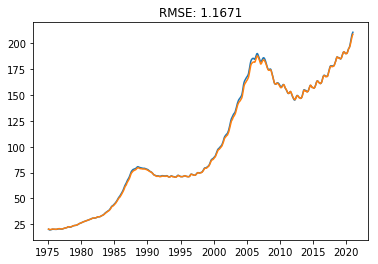

In [59]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [60]:
predictions_ARIMA.head()

Year
1975-01-31    20.250000
1975-02-28    20.325685
1975-03-31    19.918424
1975-04-30    19.839492
1975-05-31    19.934413
dtype: float64

In [61]:
xd = results513.forecast(steps=18)[0]

In [62]:
xd

array([5.35457087, 5.36055487, 5.36931013, 5.38077192, 5.39443121,
       5.40935201, 5.42419998, 5.43758435, 5.44849823, 5.45660078,
       5.46227014, 5.46646635, 5.47046082, 5.47549714, 5.48246683,
       5.49168647, 5.5028342 , 5.51505746])

In [63]:
xd = pd.Series(xd)

In [64]:
xd = pd.DataFrame(xd)

In [65]:
xd['Year'] = pd.date_range(start='1/2021', periods=18, freq='M')
xd.rename(columns={0:'HPI'},inplace=True)
xd.set_index('Year', inplace=True)

In [66]:
xd

,HPI
Year,
2021-01-31,5.354571
2021-02-28,5.360555
2021-03-31,5.369310
2021-04-30,5.380772
2021-05-31,5.394431
2021-06-30,5.409352
2021-07-31,5.424200
2021-08-31,5.437584
2021-09-30,5.448498


In [67]:
fcast = np.exp(xd)

In [68]:
fcast

,HPI
Year,
2021-01-31,211.573166
2021-02-28,212.843014
2021-03-31,214.714691
2021-04-30,217.189865
2021-05-31,220.176876
2021-06-30,223.486724
2021-07-31,226.829806
2021-08-31,229.886187
2021-09-30,232.408879


In [70]:
df_ny.tail()

,MSA,Year,HPI
Year,,,
2020-08-31,"New York-Newark-Jersey City, NY-NJ-PA",2020-08-31,202.07
2020-09-30,"New York-Newark-Jersey City, NY-NJ-PA",2020-09-30,205.01
2020-10-31,"New York-Newark-Jersey City, NY-NJ-PA",2020-10-31,207.64
2020-11-30,"New York-Newark-Jersey City, NY-NJ-PA",2020-11-30,209.57
2020-12-31,"New York-Newark-Jersey City, NY-NJ-PA",2020-12-31,210.68


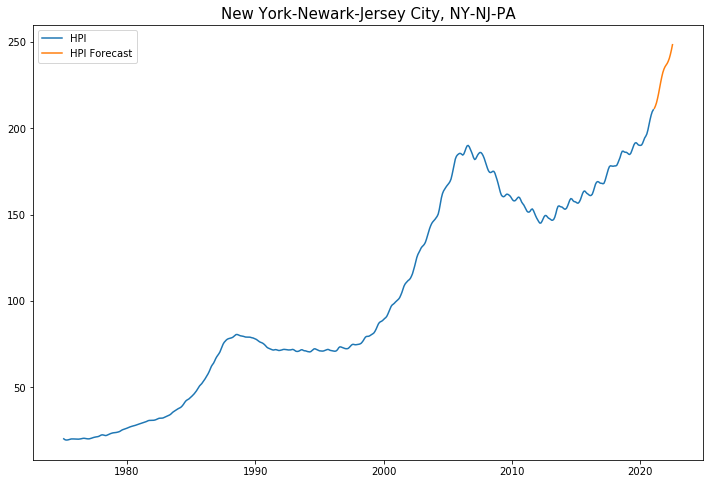

In [72]:
plt.figure(figsize=(12,8))
plt.plot(ts)
plt.plot(fcast)
plt.legend(['HPI', 'HPI Forecast'])
plt.title('New York-Newark-Jersey City, NY-NJ-PA', size=15)
plt.show()

______________________________________________

In [ ]:
# TimeSeries forecast for LA MSA

In [86]:
ts2 = df_la['HPI']
ts2.head(10)

Year
1975-01-31    15.76
1975-02-28    15.89
1975-03-31    16.16
1975-04-30    16.54
1975-05-31    16.86
1975-06-30    17.02
1975-07-31    17.16
1975-08-31    17.42
1975-09-30    17.70
1975-10-31    17.92
Name: HPI, dtype: float64

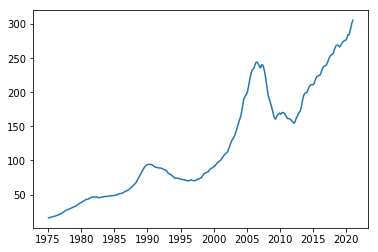

In [87]:
plt.plot(ts2)

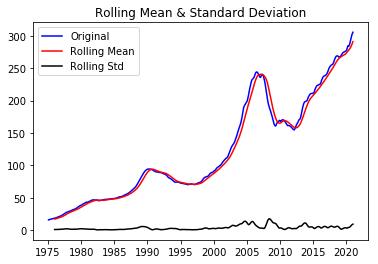

Results of Dickey-Fuller Test:
Test Statistic                   0.218703
p-value                          0.973291
#Lags Used                      19.000000
Number of Observations Used    532.000000
Critical Value (1%)             -3.442702
Critical Value (5%)             -2.866988
Critical Value (10%)            -2.569672
dtype: float64


In [88]:
test_stationarity(ts2) #not stationary because tstat > that critical values and pvalue > 5%

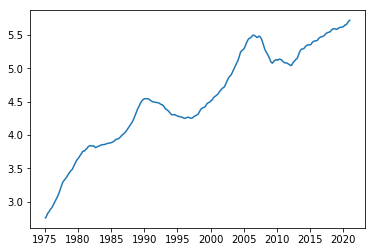

In [90]:
#take log of time series to reduce trend
ts2_log = np.log(ts2)
plt.plot(ts2_log)

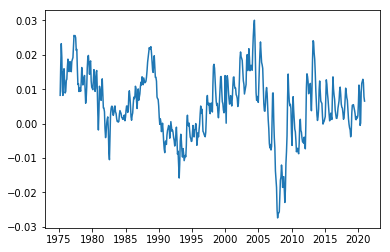

In [91]:
#take difference of logged time series to make stationary
ts2_log_diff = ts2_log - ts2_log.shift()
plt.plot(ts2_log_diff)

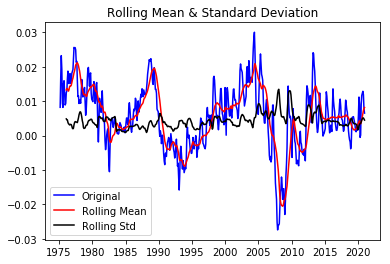

Results of Dickey-Fuller Test:
Test Statistic                  -3.175414
p-value                          0.021453
#Lags Used                      18.000000
Number of Observations Used    532.000000
Critical Value (1%)             -3.442702
Critical Value (5%)             -2.866988
Critical Value (10%)            -2.569672
dtype: float64


In [93]:
# this shows that the ts2_log_diff is stationary because tstat < critical values at 5%, and pvalue is < 5%
ts2_log_diff.dropna(inplace=True)
test_stationarity(ts2_log_diff)

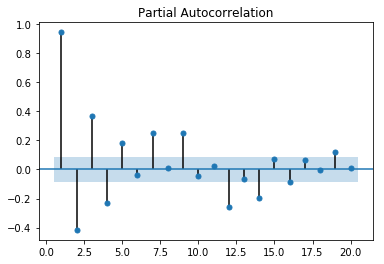

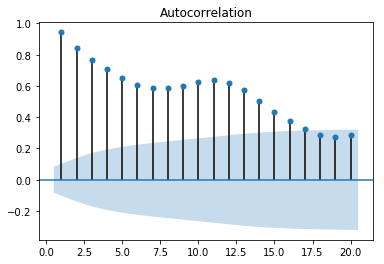

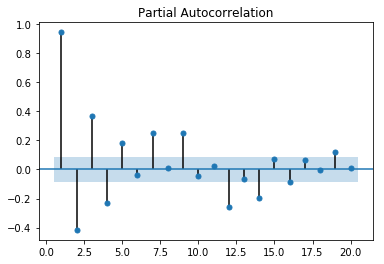

In [95]:
#use this to find ACF and PACF
sgt.plot_acf(ts2_log_diff, lags=20, zero=False)
sgt.plot_pacf(ts2_log_diff, lags=20, method='ols', zero=False)

Text(0.5, 1.0, 'RSS: 0.0026')

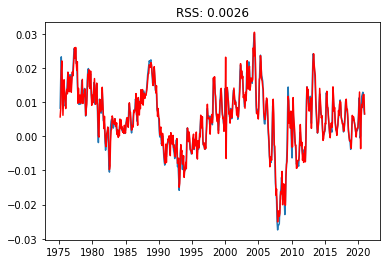

In [96]:
model515_la = ARIMA(ts2_log, order=(5,1,5))
results515_la = model515_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results515_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results515_la.fittedvalues-ts2_log_diff)**2))

In [97]:
results515_la.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 5)   Log Likelihood                2602.452
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5180.904
Time:                        13:19:31   BIC                          -5129.163
Sample:                    02-28-1975   HQIC                         -5160.686
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0056      0.002      2.675      0.007       0.002       0.010
ar.L1.D.HPI     3.4343      0.104     32.978      0.000       3.230       3.638
ar.L2.D.HPI    -5.2794      0.321    -16.453      0.000      -5.908      -4.651
ar.L3.D.HPI     4.5877      0.413     11.113      0.000       3.779       5.397
ar.L4.D.HPI    -2.3314      0.267     -8.743      0.000      -2.854      -1.809
ar.L5.D.HPI     0.5766      0.074      7.741      0.000       0.431       0.723
ma.L1.D.HPI    -1.7413      0.113    -15.384      0.000      -1.963      -1.519
ma.L2.D.HPI     0.6417      0.165      3.877      0.000       0.317       0.966
ma.L3.D.HPI     1.2341      0.059     21.055      0.000       1.119       1.349
ma.L4.D.HPI    -1.4413      0.166     -8.668      0.000      -1.767      -1.115
ma.L5.D.HPI     0.6004      0.096      6.260      0.000       0.412       0.788
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6216           -1.1105j            1.2726           -0.1688
AR.2            0.6216           +1.1105j            1.2726            0.1688
AR.3            0.8715           -0.5034j            1.0064           -0.0834
AR.4            0.8715           +0.5034j            1.0064            0.0834
AR.5            1.0573           -0.0000j            1.0573           -0.0000
MA.1           -1.0111           -0.0000j            1.0111           -0.5000
MA.2            0.9078           -0.5013j            1.0370           -0.0803
MA.3            0.9078           +0.5013j            1.0370            0.0803
MA.4            0.7981           -0.9460j            1.2377           -0.1385
MA.5            0.7981           +0.9460j            1.2377            0.1385
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0026')

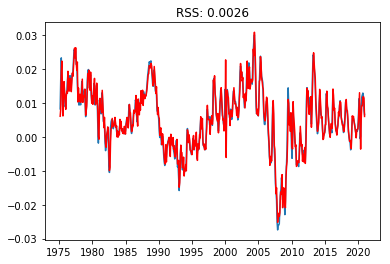

In [98]:
model514_la = ARIMA(ts2_log, order=(5,1,4))
results514_la = model514_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results514_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results514_la.fittedvalues-ts2_log_diff)**2))

In [99]:
results514_la.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 4)   Log Likelihood                2597.781
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5173.562
Time:                        13:21:45   BIC                          -5126.133
Sample:                    02-28-1975   HQIC                         -5155.029
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0060      0.004      1.536      0.125      -0.002       0.014
ar.L1.D.HPI     2.8327      0.109     26.016      0.000       2.619       3.046
ar.L2.D.HPI    -3.1710      0.269    -11.776      0.000      -3.699      -2.643
ar.L3.D.HPI     1.6978      0.252      6.735      0.000       1.204       2.192
ar.L4.D.HPI    -0.4990      0.138     -3.625      0.000      -0.769      -0.229
ar.L5.D.HPI     0.1337      0.055      2.421      0.015       0.025       0.242
ma.L1.D.HPI    -1.1641      0.109    -10.641      0.000      -1.379      -0.950
ma.L2.D.HPI    -0.3894      0.081     -4.820      0.000      -0.548      -0.231
ma.L3.D.HPI     1.2593      0.087     14.558      0.000       1.090       1.429
ma.L4.D.HPI    -0.4347      0.101     -4.323      0.000      -0.632      -0.238
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0224           -0.0000j            1.0224           -0.0000
AR.2            0.8705           -0.5041j            1.0059           -0.0835
AR.3            0.8705           +0.5041j            1.0059            0.0835
AR.4            0.4843           -2.6449j            2.6889           -0.2212
AR.5            0.4843           +2.6449j            2.6889            0.2212
MA.1           -1.0154           -0.0000j            1.0154           -0.5000
MA.2            0.8962           -0.5153j            1.0338           -0.0830
MA.3            0.8962           +0.5153j            1.0338            0.0830
MA.4            2.1197           -0.0000j            2.1197           -0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0027')

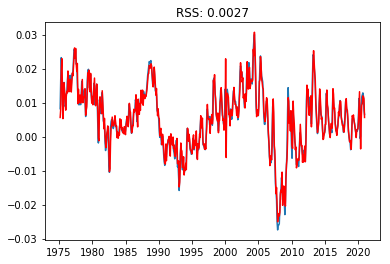

In [100]:
model513_la = ARIMA(ts2_log, order=(5,1,3))
results513_la = model513_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results513_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results513_la.fittedvalues-ts2_log_diff)**2))

In [101]:
results513.summary() ## best so far

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 3)   Log Likelihood                2743.429
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5466.859
Time:                        13:23:02   BIC                          -5423.741
Sample:                    02-28-1975   HQIC                         -5450.011
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0037      0.003      1.471      0.141      -0.001       0.009
ar.L1.D.HPI     2.9682      0.063     47.213      0.000       2.845       3.091
ar.L2.D.HPI    -3.7402      0.206    -18.196      0.000      -4.143      -3.337
ar.L3.D.HPI     2.6020      0.284      9.175      0.000       2.046       3.158
ar.L4.D.HPI    -1.1513      0.199     -5.773      0.000      -1.542      -0.760
ar.L5.D.HPI     0.3136      0.061      5.176      0.000       0.195       0.432
ma.L1.D.HPI    -1.0364      0.056    -18.537      0.000      -1.146      -0.927
ma.L2.D.HPI    -0.2779      0.099     -2.797      0.005      -0.473      -0.083
ma.L3.D.HPI     0.6084      0.050     12.179      0.000       0.510       0.706
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0291           -0.0000j            1.0291           -0.0000
AR.2            0.8814           -0.5084j            1.0175           -0.0833
AR.3            0.8814           +0.5084j            1.0175            0.0833
AR.4            0.4396           -1.6732j            1.7300           -0.2091
AR.5            0.4396           +1.6732j            1.7300            0.2091
MA.1           -1.4675           -0.0000j            1.4675           -0.5000
MA.2            0.9621           -0.4410j            1.0583           -0.0684
MA.3            0.9621           +0.4410j            1.0583            0.0684
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0030')

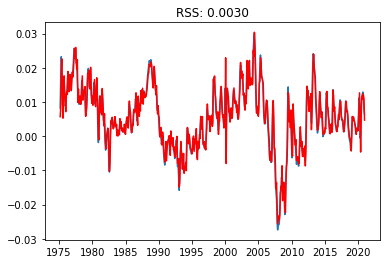

In [102]:
model512_la = ARIMA(ts2_log, order=(5,1,2))
results512_la = model512_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results512_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results512_la.fittedvalues-ts2_log_diff)**2))

In [103]:
results512_la.summary() # bad model

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(5, 1, 2)   Log Likelihood                2563.725
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5109.450
Time:                        13:24:38   BIC                          -5070.645
Sample:                    02-28-1975   HQIC                         -5094.287
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0057      0.003      2.273      0.023       0.001       0.011
ar.L1.D.HPI     1.5924      0.084     19.035      0.000       1.428       1.756
ar.L2.D.HPI    -0.6094      0.100     -6.107      0.000      -0.805      -0.414
ar.L3.D.HPI    -0.0200      0.087     -0.230      0.818      -0.190       0.151
ar.L4.D.HPI     0.0052      0.083      0.063      0.950      -0.157       0.167
ar.L5.D.HPI     0.0170      0.046      0.371      0.711      -0.073       0.107
ma.L1.D.HPI     0.1846      0.072      2.549      0.011       0.043       0.327
ma.L2.D.HPI    -0.7892      0.072    -11.035      0.000      -0.929      -0.649
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0368           -0.0000j            1.0368           -0.0000
AR.2            1.8405           -0.6530j            1.9529           -0.0543
AR.3            1.8405           +0.6530j            1.9529            0.0543
AR.4           -2.5118           -2.9299j            3.8592           -0.3628
AR.5           -2.5118           +2.9299j            3.8592            0.3628
MA.1           -1.0148           +0.0000j            1.0148            0.5000
MA.2            1.2487           +0.0000j            1.2487            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0026')

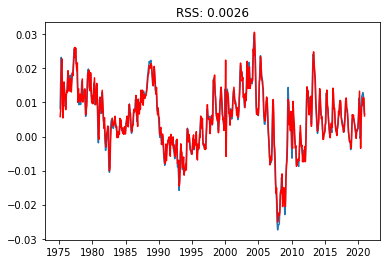

In [104]:
model415_la = ARIMA(ts2_log, order=(4,1,5))
results415_la = model415_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results415_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results415_la.fittedvalues-ts2_log_diff)**2))

In [105]:
results415.summary() #close to good but some insignif coeffs

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(4, 1, 5)   Log Likelihood                2735.209
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5448.419
Time:                        13:26:01   BIC                          -5400.990
Sample:                    02-28-1975   HQIC                         -5429.886
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0039      0.002      2.036      0.042       0.000       0.008
ar.L1.D.HPI     1.7196      0.127     13.499      0.000       1.470       1.969
ar.L2.D.HPI    -0.1771      0.325     -0.545      0.586      -0.814       0.460
ar.L3.D.HPI    -1.3276      0.308     -4.310      0.000      -1.931      -0.724
ar.L4.D.HPI     0.7658      0.110      6.987      0.000       0.551       0.981
ma.L1.D.HPI     0.2239      0.135      1.658      0.097      -0.041       0.489
ma.L2.D.HPI    -1.3840      0.089    -15.471      0.000      -1.559      -1.209
ma.L3.D.HPI    -0.1935      0.137     -1.414      0.157      -0.462       0.075
ma.L4.D.HPI     0.6950      0.072      9.668      0.000       0.554       0.836
ma.L5.D.HPI     0.1986      0.064      3.105      0.002       0.073       0.324
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1307           -0.0000j            1.1307           -0.5000
AR.2            0.9115           -0.5274j            1.0531           -0.0835
AR.3            0.9115           +0.5274j            1.0531            0.0835
AR.4            1.0415           -0.0000j            1.0415           -0.0000
MA.1            0.9968           -0.3707j            1.0635           -0.0567
MA.2            0.9968           +0.3707j            1.0635            0.0567
MA.3           -1.1925           -0.1020j            1.1969           -0.4864
MA.4           -1.1925           +0.1020j            1.1969            0.4864
MA.5           -3.1082           -0.0000j            3.1082           -0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0028')

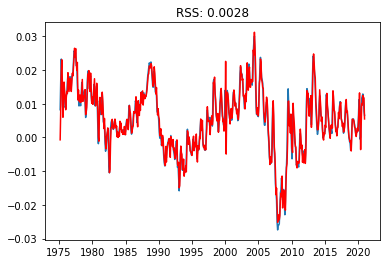

In [106]:
model414_la = ARIMA(ts2_log, order=(4,1,4))
results414_la = model414_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results414_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results414_la.fittedvalues-ts2_log_diff)**2))

In [107]:
results414_la.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(4, 1, 4)   Log Likelihood                2582.459
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5144.919
Time:                        13:27:13   BIC                          -5101.802
Sample:                    02-28-1975   HQIC                         -5128.071
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0007      0.066     -0.011      0.991      -0.130       0.129
ar.L1.D.HPI     2.8632        nan        nan        nan         nan         nan
ar.L2.D.HPI    -3.1019        nan        nan        nan         nan         nan
ar.L3.D.HPI     1.3903      0.002    824.586      0.000       1.387       1.394
ar.L4.D.HPI    -0.1518      0.002   -100.951      0.000      -0.155      -0.149
ma.L1.D.HPI    -1.2142      0.039    -31.181      0.000      -1.291      -1.138
ma.L2.D.HPI    -0.3824      0.036    -10.768      0.000      -0.452      -0.313
ma.L3.D.HPI     1.3168      0.027     48.991      0.000       1.264       1.369
ma.L4.D.HPI    -0.5004      0.042    -12.057      0.000      -0.582      -0.419
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           -0.0000j            1.0005           -0.0000
AR.2            0.8779           -0.5075j            1.0141           -0.0834
AR.3            0.8779           +0.5075j            1.0141            0.0834
AR.4            6.4044           -0.0000j            6.4044           -0.0000
MA.1           -1.0027           -0.0000j            1.0027           -0.5000
MA.2            0.9164           -0.5164j            1.0518           -0.0817
MA.3            0.9164           +0.5164j            1.0518            0.0817
MA.4            1.8016           -0.0000j            1.8016           -0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0027')

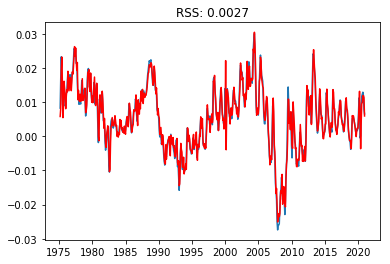

In [108]:
model314_la = ARIMA(ts2_log, order=(3,1,4))
results314_la = model314_la.fit()
plt.plot(ts2_log_diff)
plt.plot(results314_la.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results314_la.fittedvalues-ts2_log_diff)**2))

In [109]:
results314_la.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.HPI   No. Observations:                  551
Model:                 ARIMA(3, 1, 4)   Log Likelihood                2592.285
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 12 Jun 2021   AIC                          -5166.569
Time:                        13:28:11   BIC                          -5127.764
Sample:                    02-28-1975   HQIC                         -5151.406
                         - 12-31-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0058      0.003      1.905      0.057      -0.000       0.012
ar.L1.D.HPI     2.6911      0.014    189.741      0.000       2.663       2.719
ar.L2.D.HPI    -2.6580      0.025   -105.532      0.000      -2.707      -2.609
ar.L3.D.HPI     0.9577      0.014     66.883      0.000       0.930       0.986
ma.L1.D.HPI    -1.0802      0.053    -20.428      0.000      -1.184      -0.977
ma.L2.D.HPI    -0.4742      0.045    -10.611      0.000      -0.562      -0.387
ma.L3.D.HPI     1.2072      0.042     28.571      0.000       1.124       1.290
ma.L4.D.HPI    -0.3398      0.055     -6.209      0.000      -0.447      -0.233
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8699           -0.5016j            1.0042           -0.0832
AR.2            0.8699           +0.5016j            1.0042            0.0832
AR.3            1.0355           -0.0000j            1.0355           -0.0000
MA.1           -1.0120           -0.0000j            1.0120           -0.5000
MA.2            0.8951           -0.4970j            1.0238           -0.0807
MA.3            0.8951           +0.4970j            1.0238            0.0807
MA.4            2.7750           -0.0000j            2.7750           -0.0000
-----------------------------------------------------------------------------
"""

In [110]:
# bringing things back to the original scale
predictions_ARIMA_diff2 = pd.Series(results513_la.fittedvalues, copy=True)
print(predictions_ARIMA_diff2.head())

Year
1975-02-28    0.005645
1975-03-31    0.008063
1975-04-30    0.019491
1975-05-31    0.022953
1975-06-30    0.015348
dtype: float64


In [111]:
predictions_ARIMA_diff_cumsum2 = predictions_ARIMA_diff2.cumsum()
print(predictions_ARIMA_diff_cumsum2.head())

Year
1975-02-28    0.005645
1975-03-31    0.013708
1975-04-30    0.033199
1975-05-31    0.056151
1975-06-30    0.071500
dtype: float64


In [112]:
predictions_ARIMA_log2 = pd.Series(ts2_log.ix[0],index=ts2_log.index)
predictions_ARIMA_log2 = predictions_ARIMA_log2.add(predictions_ARIMA_diff_cumsum2, fill_value=0)
predictions_ARIMA_log2.head()

Year
1975-01-31    2.757475
1975-02-28    2.763120
1975-03-31    2.771183
1975-04-30    2.790674
1975-05-31    2.813627
dtype: float64

In [113]:
predictions_ARIMA_log2.tail()

Year
2020-08-31    5.680455
2020-09-30    5.692445
2020-10-31    5.704158
2020-11-30    5.715283
2020-12-31    5.720926
dtype: float64

Text(0.5, 1.0, 'RMSE: 2.2163')

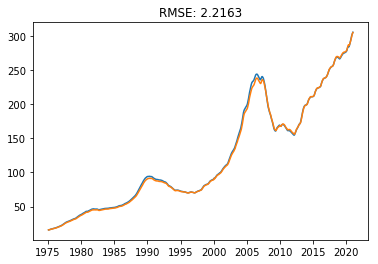

In [115]:
predictions_ARIMA2 = np.exp(predictions_ARIMA_log2)
plt.plot(ts2)
plt.plot(predictions_ARIMA2)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA2-ts2)**2)/len(ts2)))

In [116]:
predictions_ARIMA2.head()

Year
1975-01-31    15.760000
1975-02-28    15.849211
1975-03-31    15.977525
1975-04-30    16.291991
1975-05-31    16.670265
dtype: float64

In [117]:
xd_la = results513_la.forecast(steps=18)[0]

In [118]:
xd_la

array([5.73171098, 5.74175641, 5.75247882, 5.76390342, 5.77534527,
       5.7861174 , 5.7957388 , 5.80396446, 5.81087364, 5.81686173,
       5.82252822, 5.8285175 , 5.83535019, 5.84328657, 5.85226018,
       5.861899  , 5.87162782, 5.88082413])

In [119]:
xd_la = pd.Series(xd_la)

In [120]:
xd_la = pd.DataFrame(xd_la)

In [121]:
xd_la['Year'] = pd.date_range(start='1/2021', periods=18, freq='M')
xd_la.rename(columns={0:'HPI'},inplace=True)
xd_la.set_index('Year', inplace=True)

In [122]:
xd_la

,HPI
Year,
2021-01-31,5.731711
2021-02-28,5.741756
2021-03-31,5.752479
2021-04-30,5.763903
2021-05-31,5.775345
2021-06-30,5.786117
2021-07-31,5.795739
2021-08-31,5.803964
2021-09-30,5.810874


In [123]:
fcast_la = np.exp(xd_la)

In [124]:
fcast_la

,HPI
Year,
2021-01-31,308.496650
2021-02-28,311.611248
2021-03-31,314.970449
2021-04-30,318.589494
2021-05-31,322.255679
2021-06-30,325.745826
2021-07-31,328.895080
2021-08-31,331.611617
2021-09-30,333.910715


In [125]:
df_la.tail()

,MSA,HPI
Year,,
2020-08-31,"Los Angeles-Long Beach-Anaheim, CA",293.94
2020-09-30,"Los Angeles-Long Beach-Anaheim, CA",297.75
2020-10-31,"Los Angeles-Long Beach-Anaheim, CA",301.31
2020-11-30,"Los Angeles-Long Beach-Anaheim, CA",303.67
2020-12-31,"Los Angeles-Long Beach-Anaheim, CA",305.66


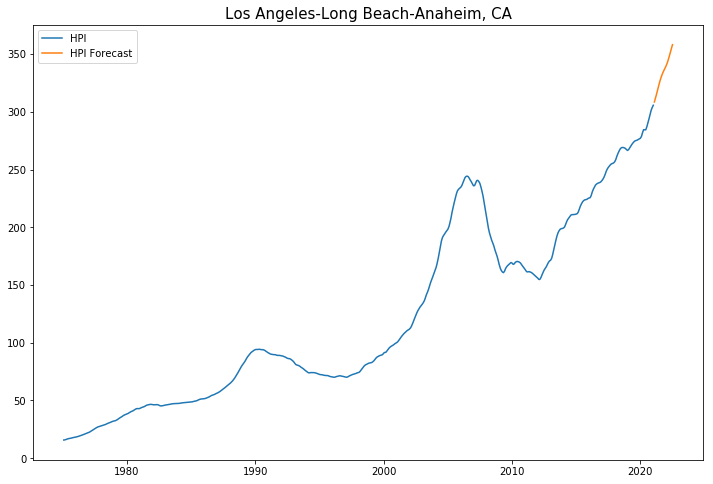

In [126]:
plt.figure(figsize=(12,8))
plt.plot(ts2)
plt.plot(fcast_la)
plt.legend(['HPI', 'HPI Forecast'])
plt.title('Los Angeles-Long Beach-Anaheim, CA', size=15)
plt.show()